### 1. Prepare/Load Data
### 2. Build Model
### 3. Fitting model
### 4. Making predictions / evaluating model
### 5. Saving and loading the model


In [9]:
import torch
from torch import nn  # contains neural network building blocks for PyTorch
import matplotlib.pyplot as plt



In [2]:
# 1. Data Preparing and loading 
# Starting with a linear regression formula

# create known parameters
weight = 0.7
bias = 0.3 

start = 0
end = 1 

step =0.02

X = torch.arange(start,end,step).unsqueeze(dim =1)
y = weight*X +bias

X[:10], y[:10], len(X), len(y)



(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [3]:
len(X),len(y)

(50, 50)

In [ ]:
# Test, Validation, Train split 
# 80% train , 20% test
train_split = int(0.8*len(X))
train_split
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

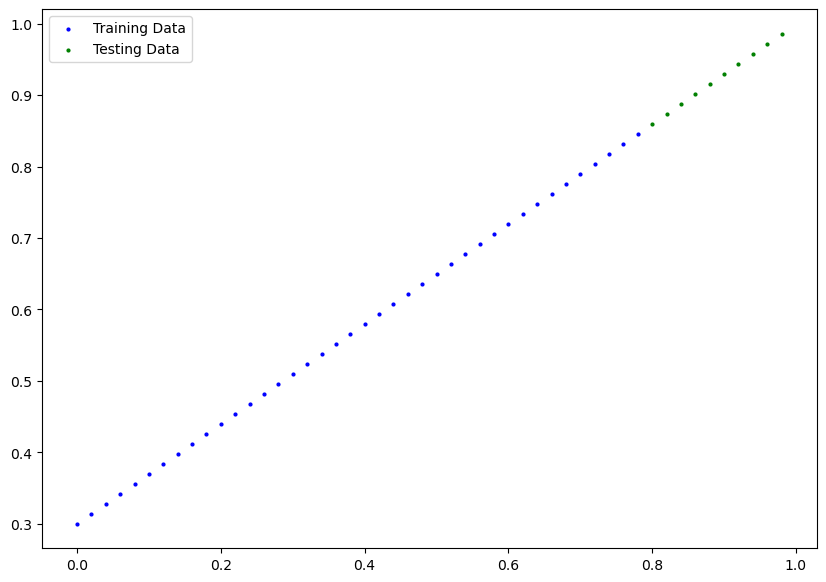

In [10]:
def plot_pred(train_data = X_train,
              train_labels=y_train,
              test_data=X_test,
              test_labels=y_test,
              predictions=None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c='b', s=4, label= 'Training Data')

    plt.scatter(test_data, test_labels, c='g', s=4, label = 'Testing Data')
    if predictions is not None:
        plt.scatter(test_data, predictions, c = 'r', s =4, label='Predictions')
    plt.legend()
plot_pred()

In [22]:
# 2. Build a Model .40

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                    requires_grad=True,
                                    dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                    requires_grad=True,
                                    dtype=torch.float))
    def forward(self, x: torch.Tensor):
            return self.weights*x + self.bias
        


### PyTorch essentials
* torch.nn = contains everything fot computational graphs (neural networks)
* torch.nn.Parameter = what parameters should the model learn 
* torch.nn.Module = The best class for all nn module, if subclassing, overwrite forward
* def forward() - all nn.module subclasses require you to overwrite forward, this method defines what happenes in the forward method






In [23]:
# Checking contents of model

# create random seed
torch.manual_seed(42)
#create an instance of the model (subclass of nn.module)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [24]:
#model output of weight and bias 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [25]:
# true values / target values 
weight, bias

(0.7, 0.3)

In [26]:
# making predicts using torch.inference
# predictive power = how well it predicts y_test based on X_test
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

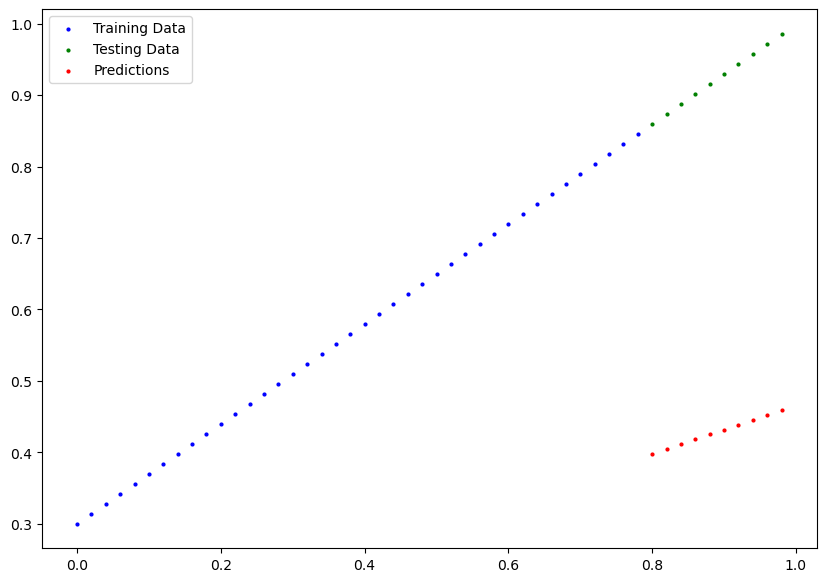

In [ ]:
plot_pred(predictions=y_preds) # initially the preds are very bad, very far away

### to measure how poor the preds are, we can use a loss funciton
"### Creating a loss function and optimizer in PyTorch\n",
    "\n",
    "For our model to update its parameters on its own, we'll need to add a few more things to our recipe.\n",
    "\n",
    "And that's a **loss function** as well as an **optimizer**.\n",
    "\n",
    "The rolls of these are: \n",
    "\n",
    "| Function | What does it do? | Where does it live in PyTorch? | Common values |\n",
    "| ----- | ----- | ----- | ----- |\n",
    "| **Loss function** | Measures how wrong your model's predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |\n",
    "| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). | \n",
    "\n",
    "Let's create a loss function and an optimizer we can use to help improve our model.\n",
    "\n",
    "Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.\n",
    "\n",
    "However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another). \n",
    "\n",
    "For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function. \n",
    "\n",
    "![what MAE loss looks like for our plot data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-mae-loss-annotated.png)\n",
    "*Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.*\n",
    "\n",
    "And we'll use SGD, `torch.optim.SGD(params, lr)` where:\n",
    "\n",
    "* `params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).\n",
    